In [27]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

Scraped 15 of the most popular hashtags (manually tried to make sure that they would include a good mix of images and hopefully good captions (based off of personal experience)). Afterwards, I eliminated all examples with "0 likes" (since then we would have no way of judging if it were good or not) and duplicates. 

In [28]:
file1 = "../../WebScraping/scrapy_instagram/scraped/hashtag/fun/17-07-2019_19"
file2 = "../../WebScraping/scrapy_instagram/scraped/hashtag/love/17-07-2019_04"
file3 = "../../WebScraping/scrapy_instagram/scraped/hashtag/dog/17-07-2019_19"
file4 = "../../WebScraping/scrapy_instagram/scraped/hashtag/instagood/17-07-2019_08"
file5 = "../../WebScraping/scrapy_instagram/scraped/hashtag/photooftheday/17-07-2019_18"
file6 = "../../WebScraping/scrapy_instagram/scraped/hashtag/food/17-07-2019_18"
file7 = "../../WebScraping/scrapy_instagram/scraped/hashtag/instafood/17-07-2019_18"
file8 = "../../WebScraping/scrapy_instagram/scraped/hashtag/tbt/17-07-2019_18"
file9 = "../../WebScraping/scrapy_instagram/scraped/hashtag/love/17-07-2019_04"
file10 = "../../WebScraping/scrapy_instagram/scraped/hashtag/style/17-07-2019_18"
file11 = "../../WebScraping/scrapy_instagram/scraped/hashtag/summer/17-07-2019_19"
file12 = "../../WebScraping/scrapy_instagram/scraped/hashtag/winter/17-07-2019_19"
file13 = "../../WebScraping/scrapy_instagram/scraped/hashtag/nature/17-07-2019_19"
file14 = "../../WebScraping/scrapy_instagram/scraped/hashtag/art/17-07-2019_19"
file15 = "../../WebScraping/scrapy_instagram/scraped/hashtag/inspiration/17-07-2019_19"
df1 = pd.read_json(file1, lines=True)
df2 = pd.read_json(file2, lines=True)  
df3 = pd.read_json(file3, lines=True)  
df4 = pd.read_json(file4, lines=True)  
df5 = pd.read_json(file5, lines=True)
df6 = pd.read_json(file6, lines=True)  
df7 = pd.read_json(file7, lines=True) 
df8 = pd.read_json(file8, lines=True) 
df9 = pd.read_json(file9, lines=True) 
df10 = pd.read_json(file10, lines=True) 
df11 = pd.read_json(file11, lines=True)
df12 = pd.read_json(file12, lines=True)
df13 = pd.read_json(file13, lines=True)
df14 = pd.read_json(file14, lines=True)
df15 = pd.read_json(file15, lines=True)

In [29]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15])

In [30]:
df = df[df.likes != 0]
df = df.drop_duplicates('id')

Some quick stats to look at the distribution of likes and comments (especially since these will be used as a training measure/a measure of how "good" a caption is)

In [31]:
print(f"Likes: \n\n{df['likes'].describe()}\n\n")
print(f"Comments: \n\n{df['comments'].describe()}\n\n")

Likes: 

count    59073.000000
mean     59.301982   
std      533.528739  
min      1.000000    
25%      5.000000    
50%      10.000000   
75%      27.000000   
max      88240.000000
Name: likes, dtype: float64


Comments: 

count    59073.000000
mean     0.071302    
std      1.386126    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      191.000000  
Name: comments, dtype: float64




We'll sort by likes and then sort by comments and take a look at the captions to see how they are. 

In [32]:
df.sort_values(by=['likes'], ascending=False)[:10]

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp
22485,How am I looking ? 😉\nKya aap sab tab bhi mujhse itna pyar karenge? \n#pvp #buddha #greyhair #stylish #potd #amusing #raghbir #love #life #bepanahpyaarr #old #oldagechallenge,0,https://scontent-mia3-1.cdninstagram.com/vp/6f405c9ed7488753fd7157dabdbdeca2/5DED7733/t51.2885-15/e35/p1080x1080/66114975_613305872493744_5830119668265920184_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089853325155976704,88240,pearlvpuri,B0ApobWl0Xg,1563349951
22217,Result Update from Blibli Indonesia Open 2019\n\nALHAMDULILLAHHHHHHHHHHHHHH\nMENANGGGGGGGGGGGGG!\nFAJAR/RIAN MELAJU KE BABAK KEDUA!\n\nMereka akan melawan Manu Attri/Sumeeth Reddy atau Liao Min Chun/Su Ching Heng di babak kedua\n\nFoto: Badmintalk\n\n#BlibliIndonesiaOpen2019 #BIO2019 #IndonesiaOpen #badmintalkindonesiaopen #juara #champion #winner\n#brilliant #amazing #incredible\n#awesome #badminton #badmintonplayer #love #indonesia #bulutangkis #羽毛球 #バドミントン #배드민턴,0,https://scontent-mia3-1.cdninstagram.com/vp/c19601f76c8d51659ba73f648ecf4335/5DA94A7A/t51.2885-15/e35/66717751_437253956864533_1035141850919819925_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089852894728616704,49541,badmintalk_com,B0ApiKfHvr8,1563349900
33540,Result Update from Blibli Indonesia Open 2019\n\nMENANGGGGGGGGGGGGG!\nTOWIN MELAJU KE BABAK KEDUA!\n\nMereka akan melawan pemenang antara Nipitphon/Savitree vs Dechapol/Sapsiree di babak kedua\n\nHasil pertandingan lainnya:\nVania Arianti Sukoco/Metya Inayah Cindiani vs Chen Qingchen/Jia Yifan\n16-21 9-21\n\nFoto: Badmintalk\n\n#BlibliIndonesiaOpen2019 #BIO2019 #IndonesiaOpen #badmintalkindonesiaopen #juara #champion #winner\n#brilliant #amazing #incredible\n#awesome #badminton #badmintonplayer #love #indonesia #bulutangkis #羽毛球 #バドミントン #배드민턴,0,https://scontent-mia3-1.cdninstagram.com/vp/b3a280a7ccf431acbe47ab129afb8cf9/5DEA6AC8/t51.2885-15/e35/66215091_2283048651786287_5898606328649034197_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089872360183058176,32369,badmintalk_com,B0At9bGnk9G,1563352221
8474,:) Follow for more here - @typewritersvoice .\n\n#typewritersvoice #poem #poetsociety #tale #story #poet #literature #reading #writing #poetry #wordgasm #quote #relationshipquotes #lovequotes #promise #microfiction #tale #story #love #relatable #sayings #relationshipquotes #quotes #truth #motivation #life #love #belief #inspiration #inspirationalquotes #quotestags #quotestagram #quoteoftheday #motivationalquote,0,https://scontent-mia3-1.cdninstagram.com/vp/eb508d8a2fdb0d4f65dec472a34425b7/5DAC1006/t51.2885-15/e35/63685964_345563066345187_3234164410299823839_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089721059398199552,22203,typewritersvoice,B0ALjtRFSk9,1563334184
26313,... e poi il mondo si ferma ! ❤️ #arteteca #sara #family #love #babygirl #mamma #amoreinfinito #noi #forever #top,0,https://scontent-mia3-1.cdninstagram.com/vp/7606eab4b623b1969f77ff8b6593afd9/5DAD267B/t51.2885-15/e35/65819433_2374287069480518_4093166300401635782_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089859900684388864,18291,artetecaofficial,B0ArIHSoEpI,1563350735
39273,Takie powroty do domu to ja rozumiem 🤪 wszędzie dobrze ale najlepiej w naszym domku 😍❤️ #me #polishgirl #gogglebox #brunette #today #homesweethome #homedecor #homedesign #love #loveit #flowers #loveisintheair #helovesme #happy #happiness #smile #warsaw #potd #mommy #gift #picoftheday #curves #curlyhair #longhair #dress #adidasoriginals,0,https://scontent-mia3-1.cdninstagram.com/vp/cc87c04afac85beef010f3fd87ca0f17/5DEB0675/t51.2885-15/e35/p1080x1080/66088507_1815515295217995_6193430865472781689_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089882265258624256,15326,sylwiabomba,B0AwNj7IQTs,1563353401
8492,Follow for more here - @typewritersvoice .\n\n#typewritersvoice #poem #poetsociety #tale #story #poet #literature #reading #writing #poetry #wordgasm #quote #relationshipquotes #lovequotes #promise #microfiction #tale #story #love #relatable #s

In [33]:
df.sort_values(by=['comments'], ascending=False)[:10]

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp
905,I’ve cut my hair and all the dust of last year has fallen off. I’ve stepped on a brand new path of my life. It’s time to move on. ......✨✨✨🔥✨✨✨....... #light #smile #freedom #fit #happiness #me #london #inspiration #like4like #photooftheday #photography #photo #believe #goodvibes #instalike #cool #italy #beautiful #lifestyle #positivevibes #happy #relax #fitness #life #instagram #instadaily #lovely #style #friends #newyork,191,https://scontent-iad3-1.cdninstagram.com/vp/108fd340d092c1877586a64afd4d6779/5DC8616B/t51.2885-15/e35/50566603_1186185518212891_6344507938883201217_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,1968881454462310912,2448,eve.juliet2018,BtS30BSFJoN,1548928981
1174,| • During times of deceit telling the truth becomes a revolutionary act • 🏀🇺🇸⛹🏾‍♂️🐃2️⃣3️⃣\n•\n•\n•\n•\n• \n#mj #michaeljordan #23 #air #jordan #charlesbarkley #oprah #show #truth #basketball #nba #airjordan #legend #talent #champion #chicago #bulls #greatness #chicagobulls #ring #collector #usa #ilovethisgame #ballislife #mvp #justdoit #nike #athlete #business #inspiration 🎲,182,https://scontent-iad3-1.cdninstagram.com/vp/4826ae9aaafc6e608994db18d170b658/5D323BB8/t51.2885-15/e15/37978338_2072816762753148_4752326779824242688_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,1840206952452205824,2481,nathanail.lemonakis,BmJunkyHi1d,1533590674
203,@sebastian.czlapinski @mateusz.miklas @yama_750r\n#love #instagood #photooftheday #tbt #cute #beautiful #me #followme #happy #follow #fashion #selfie #picoftheday #like4like #girl #tagsforlikes #instadaily #friends #summer #fun #smile #igers #instalike #likeforlike #repost #food #instamood #follow4follow #art #style,44,https://scontent-iad3-1.cdninstagram.com/vp/8f211a243124e04a48795381b2bfa1ba/5DA8A596/t51.2885-15/e35/54049616_372148293386494_3087352869139490027_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2005572773985371136,1747,mateusz.miklas,BvVOc_cl8PO,1553302927
12,"Stone sculptures are made by man. If you believe in a stone statue, you actually believe in the work of man. The stone statue that can also be smashed immediately by man. There is only one God who can create the heaven and the earth without pillars that you can see. You can only feed your spirit through the One and Only who created it💛 -\n-\n-\n-\n#God #buddha #buddhism #yoga #mindset #faith #inspire #inspiration #spiritual #zen #karma #mantra #energy #goldenbuddha #mandala #freethinker #meditation #namaste #religion #spirituality #quote #life #soul #spirit #sculpture #photography #asian #love #innerpeace #atheist",43,https://scontent-iad3-1.cdninstagram.com/vp/256b103b2c8a9057e63266c3068b2c95/5DADEDC5/t51.2885-15/e15/49907497_2178798082374163_362590393254826299_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,1962643721197361920,537,sosweetashoney,Bs8thDenpr2,1548185385
862,Episode 16: Spaces\nFind the Spaces between Things...,43,https://scontent-iad3-1.cdninstagram.com/vp/468c47952d408ac8812c2dd09d28a863/5D31FF88/t51.2885-15/e35/p1080x1080/65010757_1229383610573378_5762970171914657149_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2073679974654379264,633,monkville,BzHMPM7HYVu,1561422432
1143,#crossfit #crossfitlife #crossfitlover #functionaltraining #training #wod #gymlife #instafit #fitlife #lift #riseandgrind #pushpullgrind #sweat #motivation #inspiration #dedication #trainhard #strength #muscle #grind #strong #savage #badass #beard #instagood #follow #followme #ifb #followforfollowback,42,https://scontent-iad3-1.cdninstagram.com/vp/e6fd347312daa263ded9f64074c8363e/5DCD25F1/t51.2885-15/e35/57487940_1076211919247997_7215248036882339788_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2029356957395430912,450,luke_littlehammers,BwpuWaYBa5Q,1556138222
553,Playin' harmonica..... 🎼🎵🎶🎵🔊\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n#country #countrymusic #countrysinger #cowboy #countrymusiclover #performance #gig #instaphoto #igdaily #selfie #photogram #photographyislife #photog

Just from a cursory glance, we can see a lot of potential issues. 

The first is that there are emojis, which'll be problematic because of how this problem can be envisioned. At run time, we'll be turning an image -> descriptive features (image classification)/relevant objects -> sequence/caption. For this training data, we can simply just match the sequence up to the hashtags present in the caption as well as any image features that we find. The sequence we're going to try and convert into a sequence embedding (BERT?). This is going to be a problem with emojis because we'll have to either strip them (not ideal since I believe that they're a relevant part of captions in instagram) or find some other way of encoding them. 

The second is that this doesn't seem to be a really reliable measure. We can see that the top few results don't give the best captions. And that there's a lot of preprocessing that needs to be done (get rid of hashtags, get rid of the "credit" lines, etc). 

The third is that we have multiple languages.

Another problem is long captions. Ideally I think we only want one sequence (especially because BERT embeddings can't be of too long of sequences). One solution is to split every caption into sentences and treat each sentence as a caption. Will consider this further



/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 250)

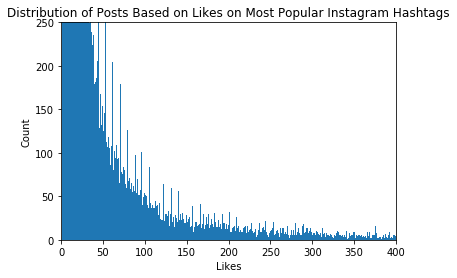

In [34]:
plt.hist(df["likes"], bins='auto')
plt.title("Distribution of Posts Based on Likes on Most Popular Instagram Hashtags")
plt.xlabel("Likes")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=400)
plt.ylim(ymin=0, ymax=250)

(0, 100)

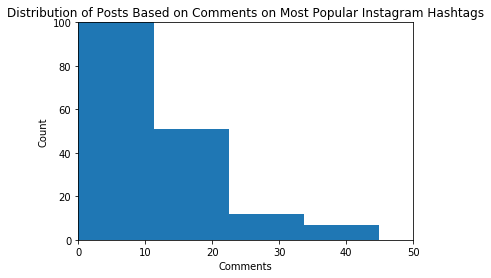

In [35]:
plt.hist(df["comments"], bins='auto')
plt.title("Distribution of Posts Based on Comments on Most Popular Instagram Hashtags")
plt.xlabel("Comments")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=50)
plt.ylim(ymin=0, ymax=100)

In an attempt to try and see what would be a good representation of how good a caption is, I'll try different weightings of comments and likes below. I'm personally really liking the top few results when sorting by comments, so I'll have to try and weight that to be worth more.


In [36]:
#df['caption_rating'] = df['likes'] + df['comments']
#df['caption_rating'] = df.loc[: , "likes":"comments"].mean(axis=1)
df['caption_rating'] = (0.1*df['likes'] + 50*df['comments'])/2

In [37]:
df.sort_values(by=['caption_rating'], ascending=False)[:20]

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,caption_rating
905,I’ve cut my hair and all the dust of last year has fallen off. I’ve stepped on a brand new path of my life. It’s time to move on. ......✨✨✨🔥✨✨✨....... #light #smile #freedom #fit #happiness #me #london #inspiration #like4like #photooftheday #photography #photo #believe #goodvibes #instalike #cool #italy #beautiful #lifestyle #positivevibes #happy #relax #fitness #life #instagram #instadaily #lovely #style #friends #newyork,191,https://scontent-iad3-1.cdninstagram.com/vp/108fd340d092c1877586a64afd4d6779/5DC8616B/t51.2885-15/e35/50566603_1186185518212891_6344507938883201217_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,1968881454462310912,2448,eve.juliet2018,BtS30BSFJoN,1548928981,4897.40
1174,| • During times of deceit telling the truth becomes a revolutionary act • 🏀🇺🇸⛹🏾‍♂️🐃2️⃣3️⃣\n•\n•\n•\n•\n• \n#mj #michaeljordan #23 #air #jordan #charlesbarkley #oprah #show #truth #basketball #nba #airjordan #legend #talent #champion #chicago #bulls #greatness #chicagobulls #ring #collector #usa #ilovethisgame #ballislife #mvp #justdoit #nike #athlete #business #inspiration 🎲,182,https://scontent-iad3-1.cdninstagram.com/vp/4826ae9aaafc6e608994db18d170b658/5D323BB8/t51.2885-15/e15/37978338_2072816762753148_4752326779824242688_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,1840206952452205824,2481,nathanail.lemonakis,BmJunkyHi1d,1533590674,4674.05
22485,How am I looking ? 😉\nKya aap sab tab bhi mujhse itna pyar karenge? \n#pvp #buddha #greyhair #stylish #potd #amusing #raghbir #love #life #bepanahpyaarr #old #oldagechallenge,0,https://scontent-mia3-1.cdninstagram.com/vp/6f405c9ed7488753fd7157dabdbdeca2/5DED7733/t51.2885-15/e35/p1080x1080/66114975_613305872493744_5830119668265920184_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089853325155976704,88240,pearlvpuri,B0ApobWl0Xg,1563349951,4412.00
22217,Result Update from Blibli Indonesia Open 2019\n\nALHAMDULILLAHHHHHHHHHHHHHH\nMENANGGGGGGGGGGGGG!\nFAJAR/RIAN MELAJU KE BABAK KEDUA!\n\nMereka akan melawan Manu Attri/Sumeeth Reddy atau Liao Min Chun/Su Ching Heng di babak kedua\n\nFoto: Badmintalk\n\n#BlibliIndonesiaOpen2019 #BIO2019 #IndonesiaOpen #badmintalkindonesiaopen #juara #champion #winner\n#brilliant #amazing #incredible\n#awesome #badminton #badmintonplayer #love #indonesia #bulutangkis #羽毛球 #バドミントン #배드민턴,0,https://scontent-mia3-1.cdninstagram.com/vp/c19601f76c8d51659ba73f648ecf4335/5DA94A7A/t51.2885-15/e35/66717751_437253956864533_1035141850919819925_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089852894728616704,49541,badmintalk_com,B0ApiKfHvr8,1563349900,2477.05
33540,Result Update from Blibli Indonesia Open 2019\n\nMENANGGGGGGGGGGGGG!\nTOWIN MELAJU KE BABAK KEDUA!\n\nMereka akan melawan pemenang antara Nipitphon/Savitree vs Dechapol/Sapsiree di babak kedua\n\nHasil pertandingan lainnya:\nVania Arianti Sukoco/Metya Inayah Cindiani vs Chen Qingchen/Jia Yifan\n16-21 9-21\n\nFoto: Badmintalk\n\n#BlibliIndonesiaOpen2019 #BIO2019 #IndonesiaOpen #badmintalkindonesiaopen #juara #champion #winner\n#brilliant #amazing #incredible\n#awesome #badminton #badmintonplayer #love #indonesia #bulutangkis #羽毛球 #バドミントン #배드민턴,0,https://scontent-mia3-1.cdninstagram.com/vp/b3a280a7ccf431acbe47ab129afb8cf9/5DEA6AC8/t51.2885-15/e35/66215091_2283048651786287_5898606328649034197_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2089872360183058176,32369,badmintalk_com,B0At9bGnk9G,1563352221,1618.45
203,@sebastian.czlapinski @mateusz.miklas @yama_750r\n#love #instagood #photooftheday #tbt #cute #beautiful #me #followme #happy #follow #fashion #selfie #picoftheday #like4like #girl #tagsforlikes #instadaily #friends #summer #fun #smile #igers #instalike #likeforlike #repost #food #instamood #follow4follow #art #style,44,https://scontent-iad3-1.cdninstagram.com/vp/8f211a243124e04a48795381b2bfa1ba/5DA8A596/t51.2885-15/e35/54049616_372148293386494_3087352869139490027_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,200557277

This has given me the best results so far (but of course, it's only looking at the top 20). I'm going to need a much better/consistent indicator. The first choice would be to normalize it amongst another factor, the first of which comes to mind is of course the user's number of followers. Luckily, we've kept the username of where each training example came from, so we can easily scrape that and then merge our results together.

In [38]:
with open("users.txt", 'w') as f:
    for x in df['owner_name']:
        f.write(f"{x}\n")

The above line is writing all of the usernames to a file that I'll then send through to another spider to scrape the number of followers they have. Below, I'll load in the results of that and merge it with my previous dataframe (luckily, there's a nice function that allows for this).

In [39]:
userfile = "../../WebScraping/scrapy_instagram/scraped/user/18-07-2019_02"
user_df = pd.read_json(userfile, lines=True)
user_df = user_df.rename(columns={'user': 'owner_name'})

df = pd.merge(df, user_df, on='owner_name')

In [40]:
df
#df['followers'].describe()
#df.replace({'followers': {0: }})

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,caption_rating,followers
0,🌅\n.\n.\n.\n.\n.\n#boanoite #sunset #nature #travel #peace #photo \n#love #instagood #me #cute #follow #like #photooftheday #followme #tagsforlikes #beautiful #picoftheday #happy #instadaily #summer #igers #fun #smile #bestoftheday #aventura #wanderlust #fromwhereistand #instatravel #travelgram #tourism,0,https://scontent-iad3-1.cdninstagram.com/vp/1f95de21222329b516a466570b2661ca/5DBE1639/t51.2885-15/e35/66845209_156772702044232_6180775666612334884_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2090312387240736000,2,photsflima,B0CSAqPFTVY,1563404676,0.10,127
1,🌅\n.\n.\n.\n.\n.\n#boanoite #sunset #nature #travel #peace #photo \n#love #instagood #me #cute #follow #like #photooftheday #followme #tagsforlikes #beautiful #picoftheday #happy #instadaily #summer #igers #fun #smile #bestoftheday #aventura #wanderlust #fromwhereistand #instatravel #travelgram #tourism,0,https://scontent-iad3-1.cdninstagram.com/vp/2e384ebbe24bb698fa33262ae12d2d6c/5DB81561/t51.2885-15/e35/66428092_551269885406933_4989025943742359790_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2090311566541441792,16,photsflima,B0CR0t5l8sf,1563404578,0.80,127
2,"Frio, porém, sem chuva 🙏🏻\n.\n.\n.\n.\n.\n#boanoite #sunset #nature #travel #peace #photo \n#love #instagood #me #cute #follow #like #photooftheday #followme #tagsforlikes #beautiful #picoftheday #happy #instadaily #summer #igers #fun #smile #bestoftheday #aventura #wanderlust #fromwhereistand #instatravel #travelgram #tourism",0,https://scontent-iad3-1.cdninstagram.com/vp/aca9385655b96c5b59f15814547e9332/5DCC6FD6/t51.2885-15/e35/65946619_869384040104627_1001704786701917387_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2090288424804442368,6,photsflima,B0CMj9elGD-,1563401819,0.30,127
3,Natureza ❤\n.\n.\n.\n.\n.\n#boanoite #sunset #nature #travel #peace #photo \n#love #instagood #me #cute #follow #like #photooftheday #followme #tagsforlikes #beautiful #picoftheday #happy #instadaily #summer #igers #fun #smile #bestoftheday #aventura #wanderlust #fromwhereistand #instatravel #travelgram #tourism,0,https://scontent-iad3-1.cdninstagram.com/vp/23ea5a1f0ad927b232a33a57f67ecfd5/5DA9CA2E/t51.2885-15/e35/66396820_160239051773618_3566167267759366429_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2090313694479598080,12,photsflima,B0CSTrsl0IT,1563404832,0.60,127
4,🐕 > people,0,https://scontent-iad3-1.cdninstagram.com/vp/5b2e993e856aafe9579f7180d33a07ae/5DBB4BC9/t51.2885-15/e35/s1080x1080/62252689_2492445294152371_1441823122046929587_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2064839273992777216,183,pandoras_box_muncher,BynyGE0nW3r,1560368044,9.15,85
5,#me #ben #my #friends #happy #fun #smile #lol #eat #yummy #food #delicious #instagood #beauty #love #drunk #alcohol #raki #photo #follow #summer #night #istanbul #goodnight #gutenacht #спокойнойночи #buenasnoches #boanoite #buonanotte #iyigeceler,0,https://scontent-iad3-1.cdninstagram.com/vp/7378e74ce4dd0eba07c3954e0eecde74/5DEB808D/t51.2885-15/e35/66410395_155120708977423_3283059251728028442_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2087308838234651648,88,1905ali1905ali,Bz3nFRPgnv2,1563046625,4.40,78
6,❤😘 Always look on the bright side of life 😘❤\n-\n-\n❤ love ❤\n-\n-\n-\n#ginger #queen #pose #photography #me #selfie #ginger #hair #girl #pretty #cute #fun #portraitphotography #alternative #smiles #beautiful #beauty #makeup #alternativegirl #selca #fashion #choker #happy #instagood #instagram #redhead #selflove #motivation #freckles #onlyfans 😈😇😈😇,0,https://scontent-iad3-1.cdninstagram.com/vp/51c4c1aafe8e9a45aea77b684fb3b693/5DB67A6E/t51.2885-15/e35/66365162_215205652778276_2762561968716301327_n.jpg?_nc_ht=scontent-iad3-1.cdninstagram.com,2089632291373691648,374,kirsty_wendy_,Bz_3X9mg7NJ,1563323602,18.70,6318
7,❤😇😍😍 Saturday 😍😍😇❤\n-\n-\n❤😘 Got to post abit earlier today cuz I'm off out to my first day party in a long while 😂 should be a pretty good day 😘❤\n-\n-\n🔥 Have